In [1]:
import os
import cv2
from matplotlib import pyplot as plt
from unet_project.image_utils import ImageUtils
from unet_project.data_augmentation import DataAugmentation
from unet_project.u_net import Unet
from unet_project.create_patches import PatchesCreator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm_notebook
import numpy as np
from imgaug import augmenters as iaa
from unet_project.image_utils import ImageUtils
from unet_project.create_patches import PatchesCreator


Using TensorFlow backend.


In [7]:
path_to_imgs = '/home/ajuska/Dokumenty/Skola/diplomka/custom_train/train_imgs/train'
path_to_masks = '/home/ajuska/Dokumenty/Skola/diplomka/custom_train/train_masks/train'
img_height = 224
img_width = 224
img_channels = 3

image_ut = ImageUtils(path_to_imgs, path_to_masks, img_height, img_width, architecture='unet')
patches_cr = PatchesCreator(None, None, img_height, img_width)

In [6]:
def augmentation():
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)

    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Crop(percent=(0, 0.1)), 
        iaa.GaussianBlur((0, 1.0)), 
#         iaa.OneOf([
#             iaa.Dropout((0.01, 0.1), per_channel=0.1), 
#             iaa.CoarseDropout((0.05, 0.1), size_percent=(0.05, 0.08), per_channel=0.1),
#         ]),
        iaa.ContrastNormalization((0.9, 1.1)),
        iaa.Multiply((0.9, 1.1), per_channel=0.1),
        sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1))),
        iaa.Affine(
            scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
            rotate=(-0.01, 0.01),
            shear=(-8, 8)
        )
    ], random_order=True) 
    return seq

seq = augmentation()

In [8]:
def data_gen(path_to_imgs, path_to_masks, batch_size):
    names = os.listdir(path_to_imgs)
    random.shuffle(names)
    while 1:
        img = []
        mask = []       
        all_aug_im = []
        all_aug_ma = []
        
        for idx in range(4):
            train_img = image_ut.normalized(cv2.imread(path_to_imgs+'/'+names[idx]))#/255
#             train_img =  cv2.resize(train_img, (img_height, img_width))
            img.append(train_img)
            
            train_mask = cv2.imread(path_to_masks+'/'+names[idx], cv2.IMREAD_GRAYSCALE)#/255
#             train_mask = cv2.resize(train_mask, (img_height, img_width))
#             train_mask = train_mask.reshape(img_height, img_width, 1)
            mask.append(train_mask)
        
        for i in range(2):
            seq = augmentation()
            seq_det = seq.to_deterministic()
            images_aug = seq_det.augment_images(np.array(img).astype(np.uint8))    
            mask_aug = seq_det.augment_images(np.array(mask).astype(np.uint8))
            for im in range(len(images_aug)):
                all_aug_im.append(images_aug[im])
                all_aug_ma.append(mask_aug[im])
        
        for idx in range(len(all_aug_im)):
            img.append(all_aug_im[idx])
            mask.append(all_aug_ma[idx])
        
        patches_cr = PatchesCreator(img, mask, img_height, img_width)
        img_patches, mask_patches = patches_cr.create_patches()

        imgs = [x/255 for x in img_patches]
        masks = [y/255 for y in mask_patches]
        
        cnt_im = math.floor(len(imgs)/batch_size)
        inkr = 0
        for i in range(cnt_im):
            start = 0+inkr
            stop = 0+inkr+batch_size
            batch_imgs = imgs[start:stop]
            batch_masks = masks[start:stop]
            inkr = inkr + batch_size
            yield np.array(batch_imgs), np.array(batch_masks)
        
train_frame_path = '/home/ajuska/Dokumenty/Skola/diplomka/custom_train/train_imgs/train'
train_mask_path = '/home/ajuska/Dokumenty/Skola/diplomka/custom_train/train_masks/train'

val_frame_path = '/home/ajuska/Dokumenty/Skola/diplomka/custom_train/val_imgs/val'
val_mask_path = '/home/ajuska/Dokumenty/Skola/diplomka/custom_train/val_masks/val'

# Train the model
train_gen = data_gen(train_frame_path, train_mask_path, batch_size=4)
val_gen = data_gen(val_frame_path, val_mask_path, batch_size=4)

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
import random
import math

NO_OF_TRAINING_IMAGES = len(os.listdir('/home/ajuska/Dokumenty/Skola/diplomka/custom_train/train_imgs/train'))
NO_OF_VAL_IMAGES = len(os.listdir('/home/ajuska/Dokumenty/Skola/diplomka/custom_train/val_imgs/val/'))

NO_OF_EPOCHS = 50

BATCH_SIZE = 8

unet = Unet(img_height=img_height, img_width=img_width, img_channels=img_channels)
model = unet.create_model()
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model_unet_vessels.h5', verbose=1, save_best_only=True)

callbacks_list = [checkpointer, earlystopper]

results = model.fit_generator(train_gen, epochs=NO_OF_EPOCHS, 
                              steps_per_epoch = (NO_OF_TRAINING_IMAGES//BATCH_SIZE),
                              validation_data=val_gen, 
                              validation_steps=(NO_OF_VAL_IMAGES//BATCH_SIZE), 
                              callbacks=callbacks_list,
                              verbose=1)

Creating model.
Epoch 1/50
Creating patches.
Creating patches.
11/11 [==============================] - 33s 3s/step - loss: 0.6123 - acc: 0.6942 - val_loss: 0.4639 - val_acc: 0.8492

Epoch 00001: val_loss improved from inf to 0.46394, saving model to model_unet_vessels.h5
Epoch 2/50
11/11 [==============================] - 27s 2s/step - loss: 0.4938 - acc: 0.8137 - val_loss: 0.4649 - val_acc: 0.8746

Epoch 00002: val_loss did not improve from 0.46394
Epoch 3/50
 1/11 [=>............................] - ETA: 24s - loss: 0.5272 - acc: 0.7475

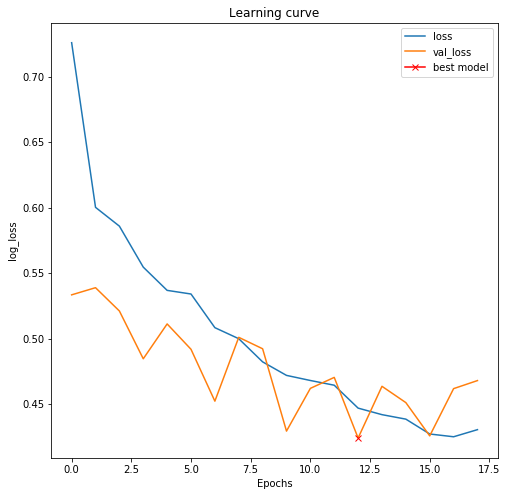

In [6]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [7]:
# serialize model to JSON
model_json = model.to_json()
with open("model_unet_vessels_lab.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_unet_vessels_lab.h5")
print("Saved model to disk")

Saved model to disk


In [8]:
test_img = cv2.imread('/home/ajuska/Dokumenty/Skola/diplomka/disk/val_imgs/val/Study_02_00041_01_R_registered.avi_average_image.tif')/255
test_img =  cv2.resize(test_img, (224, 224))

test_mask = cv2.imread('/home/ajuska/Dokumenty/Skola/diplomka/disk/val_masks/val/Study_02_00041_01_R_registered.avi_average_image.tif', cv2.IMREAD_GRAYSCALE)/255
test_mask = cv2.resize(test_img, (224, 224))

In [9]:
test = np.expand_dims(test_img, axis=0)
preds = model.predict(test)

In [23]:
preds_t = (preds > 0.1)
prediction = np.squeeze(preds_t*1)

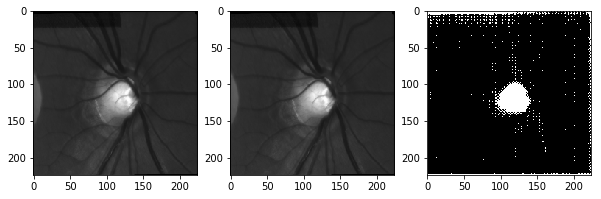

In [24]:
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(test_img)
plt.subplot(132)
plt.imshow(test_mask, cmap='gray')
plt.subplot(133)
plt.imshow(prediction, cmap='gray')

In [25]:
from skimage import data, color
from skimage import measure
from scipy.signal import medfilt2d

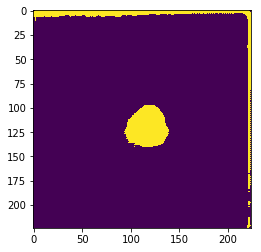

In [26]:
test_img_filtered = medfilt2d(prediction.astype(np.uint8), 5)
plt.imshow(test_img_filtered)

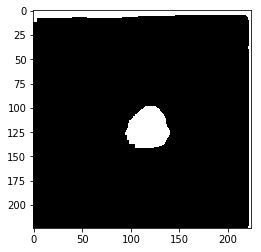

In [27]:
kernel = np.ones((12,12),np.uint8)
closing = cv2.morphologyEx(test_img_filtered, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing, cmap='gray')

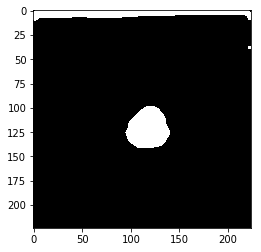

In [28]:
opening = medfilt2d(closing.astype(np.uint8), 5)
plt.imshow(opening, cmap='gray')

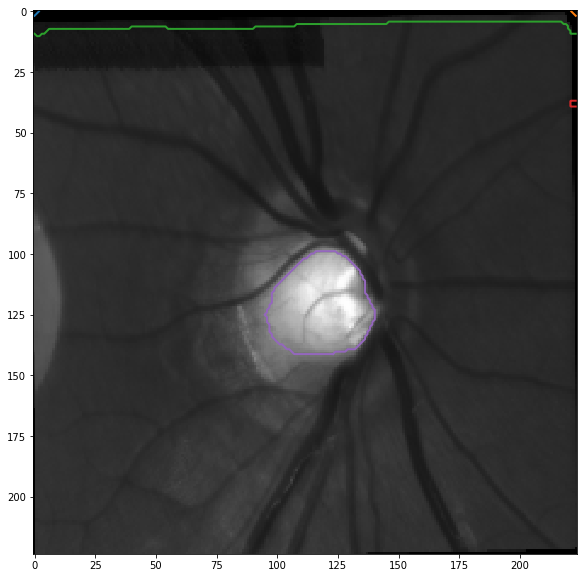

In [29]:
contours = measure.find_contours(opening, 0.8)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(test_img, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)